In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
# TODO: Create a generic CDF function instead of creating 3 seperate ones for each type of user

def generate_CDF(data):
    pass

    temp_depression = data['num_words_post'].value_counts().sort_index()
    temp_depression /= np.sum(temp_depression.values)
    depression_indice_list = temp_depression.index
    temp_depression = temp_depression.reset_index().drop('index',axis=1)
    CDF_depression = np.zeros(len(temp_depression))
    CDF_depression[0] = temp_depression.iloc[0,0]


    for i in range(1, len(temp_depression)):
        CDF_depression[i] = CDF_depression[i-1] + temp_depression.iloc[i,0]
    return CDF_depression, depression_indice_list

    
    
def vector_transformers(text_column):

    count_vect = CountVectorizer()
    post_text = count_vect.fit_transform(text_column)

    tfidf_transformer = TfidfTransformer()
    post_text_tfidf = tfidf_transformer.fit_transform(post_text)

    return post_text_tfidf


# Clean dataset
def clean_data(dataset):
#     dataset = dataset[dataset['subreddit'] != 'depression']
#     dataset = dataset[dataset['subreddit'] != 'AskReddit']
    dataset['post_text'] = dataset['post_text'].fillna('')
    dataset = dataset[dataset['post_text'] != '[removed]']
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\r', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\n', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace("\'", ""))
    dataset = dataset.dropna()
    dataset = dataset.reset_index()

    return dataset

def post_to_wordlist(post, remove_stopwords=True, split=False):
    
    post = re.sub("[^a-zA-Z]"," ", post)
    words = post.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if split:
        return words
    else:
        return (' '.join(words))

In [3]:
# Load the data and clean it.
# if you have internet connection use the markdown below instead of this code block
# use this one only if you have the data file saved on your machine
df = pd.read_csv(r'/Users/giladgecht/Downloads/temp.csv')

df = shuffle(df)
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

df = pd.read_csv('temp.csv')
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

In [4]:
target = '_subreddit'
cols = '_title'

X = df[cols]
y = df[target]

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [7]:
print("Accuracy Score:",score)
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

Accuracy Score: 0.8705467372134039
[[1606  149]
 [ 218  862]]
AUC Score: 0.9374009429066301


In [8]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['reddit' 'redditors' 'movie' 'hype' 'did' 'snack' 'askreddit' 'thing'
 'hermaphrodite' 'bugger']

Largest Coefs: 
['depression' 'suicide' 'depressed' 'therapist' 'therapy' 'suicidal'
 'feels' 'bed' 'feel' 'depressive']



In [9]:
# Load main dataset and clean it by removing deleted posts and filling presumed posts with pictures with ''
# Apply the trained LinearSVC classifier on the dataset
whole_data = pd.read_csv(r'/Users/giladgecht/PycharmProjects/DepressionResearch/Create_Data/SubmissionsDF.csv',index_col=0)
whole_data = clean_data(whole_data)
whole_data['predicted'] = svc.predict(count_vect.transform(whole_data['title']))

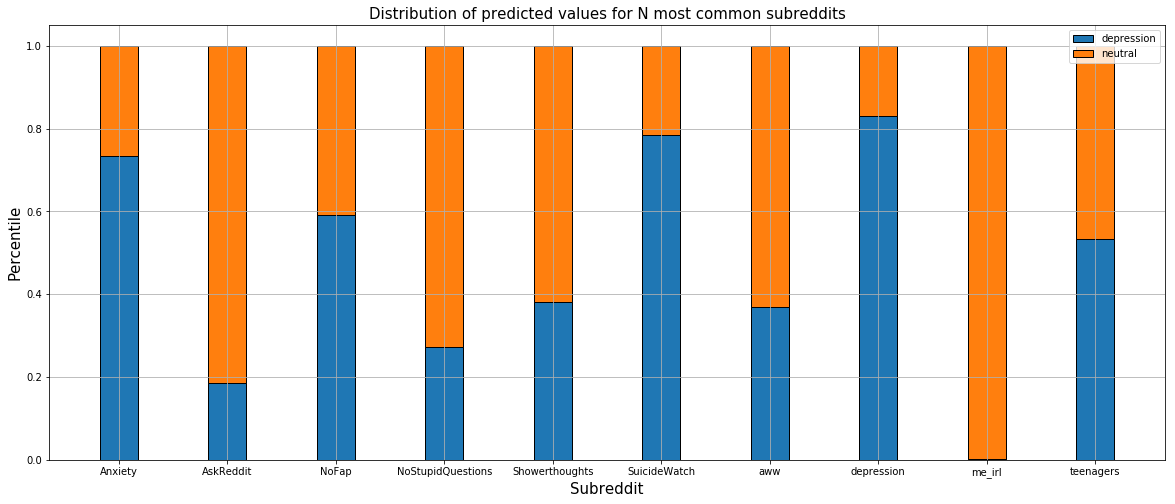

In [10]:
# for the top n common subreddits (probably depression related)
# plot the distribution of predicted neutral posts vs depression posts 
# i.e. subreddit = 'depression', num_posts = 3000, predicted_1 = 2500 (depression), predicted_0 


N = 10
most_common_subreddits = list(whole_data['subreddit'].value_counts().nlargest(N).keys())
most_common_subreddits = whole_data[whole_data['subreddit'].isin(most_common_subreddits)]

temp = most_common_subreddits['subreddit'].value_counts()
sum_subreddit_dict = temp.to_dict()

temp = most_common_subreddits.groupby(['subreddit','predicted'], as_index=False).agg({"submission_id":"count"})
temp['appearance'] = temp['subreddit'].apply(lambda x: sum_subreddit_dict[x])
temp['submission_id'] /= temp['appearance']

pred_depression = temp.iloc[1::2,:]
pred_neutral = temp.iloc[::2,:]

ind = np.arange(N)
width = .35
plt.figure(figsize=(20,8))
p1 = plt.bar(ind, pred_depression['submission_id'], width, edgecolor='k', label='depression')
p2 = plt.bar(ind, pred_neutral['submission_id'], width, edgecolor='k', label='neutral',bottom=pred_depression['submission_id'])


plt.title("Distribution of predicted values for N most common subreddits", size=15)
plt.ylabel('Percentile',size=15)
plt.xlabel('Subreddit', size=15)
plt.xticks(ind, list(pred_depression['subreddit'].values))
plt.legend()
plt.grid()
plt.show()


In [11]:
# Distribution of predicted values
whole_data['predicted'].value_counts()

0    62695
1    48096
Name: predicted, dtype: int64

In [12]:
# Filter out the data by noise
# Subreddits with less than 50 appearences are dropped out 
counts = whole_data['subreddit'].value_counts()
popular_subreddits = counts[counts.values >= 50].keys()
whole_data = whole_data[(whole_data['subreddit'].isin(popular_subreddits))]

In [13]:
# Number of UNIQUE subreddits left after being filtered
subreddits = set(whole_data['subreddit'])
len(subreddits)

338

In [14]:
# Apply a second filter,
# by checking the tendency of a certain subreddit to be either depression or neutral
# if its over 70% towards a certain side, append to the appropriate list

neutral_subreddits = []
depression_subreddits = []
for i in subreddits:
    values = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values
    sum_values = np.sum(whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values)
    values_perc = values/sum_values
    value1 = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values[0]
    if whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().keys()[0] == 0:
        if values_perc[0] >= 0.7:
            neutral_subreddits.append(i)
    else:
        if values_perc[0] >= 0.7:
            depression_subreddits.append(i)

In [15]:
# Distribution of depression subreddits 
whole_data[whole_data['subreddit'].isin(depression_subreddits)]['subreddit'].value_counts()

depression             13728
SuicideWatch            1356
Anxiety                  891
offmychest               633
mentalhealth             425
selfharm                 394
relationship_advice      327
relationships            270
lonely                   251
Needafriend              153
DoesAnybodyElse          112
TrueOffMyChest           108
Vent                     104
depression_help           95
selfimprovement           68
dogs                      64
AmItheAsshole             62
leaves                    54
Name: subreddit, dtype: int64

In [16]:
print("The Filtered Neutral Subreddits Are:\n",neutral_subreddits)
print(20*"-")
print("The Filtered Depression Subreddits are:\n", depression_subreddits)

The Filtered Neutral Subreddits Are:
 ['CrappyDesign', 'eu4', 'Libertarian', 'vegan', 'reddeadredemption', 'news', 'AskMen', 'todayilearned', 'PewdiepieSubmissions', 'nottheonion', 'mildlyinteresting', 'MaddenUltimateTeam', 'circlejerk', 'ShitPostCrusaders', 'Blackops4', 'FIFA', 'AskReddit', 'Warframe', 'StarWars', 'movies', 'horror', 'CrusaderKings', 'worldnews', 'Tekken', 'iamverysmart', 'youtube', 'leagueoflegends', 'pokemon', 'gtaonline', 'FreeMorocco', 'anime', 'nba', 'pokemongo', 'gaming', 'starterpacks', 'ireland', '2meirl4meirl', 'nfl', 'travel', 'youtubehaiku', 'lewronggeneration', 'politics', 'nostalgia', 'danganronpa', 'suggestmeabook', 'travisscott', 'conspiracy', 'DnD', 'KotakuInAction', 'assholedesign', 'hmmm', 'MoviePassClub', 'vinyl', 'atheism', 'walmart', 'brasil', 'itookapicture', 'Music', 'DarkSouls2', 'memes', 'videos', 'anime_irl', 'fo4', 'learnprogramming', 'ladyladyboners', 'meirl', 'explainlikeimfive', 'StarWarsBattlefront', 'Cigarettes', 'food', 'whatisthisthin

In [17]:
# Filtered by hand depression-related subreddits
depression_subreddit_filtered_list = ['depression_help', 'lonely', 'SuicideWatch', 'depression',
                                      'selfharm', 'mentalhealth', 'offmychest', 'Anxiety',]

In [18]:
# Split the dataframe to neutral and depressed by the filtered subreddits
depression_df = whole_data[whole_data['subreddit'].isin(depression_subreddit_filtered_list)]
neutral_df = whole_data[whole_data['subreddit'].isin(neutral_subreddits)]

In [19]:
# Get the list of all unique users for each type of dataset
depression_names = list(set(depression_df['user_name']))
neutral_names = list(set(neutral_df['user_name']))

In [20]:
# Merge them back to a single dataframe
full_df = pd.concat([depression_df,neutral_df],axis=0)
full_df.shape

(34572, 16)

In [21]:
# Filter out people who havn't posted in both types of subreddits (Depression/Neutral) in the current dataset
both = []
for i in depression_names:
    if i in neutral_names:
        both.append(i)

In [22]:
full_df = full_df[full_df['user_name'].isin(both)]
full_df = full_df.sort_values(by=['user_name','date_created'],ascending=False)

In [23]:
full_df.shape

(25339, 16)

In [24]:
# Find by using regular expressions all the sentences
# which are built in the following way: "i ...... depress/ed/ion/ants and so on"

count = 0
sentences = []
post = []
subreddits = []
for row in full_df.iterrows():
    
    sentence = row[1]['post_text']
    bla = re.findall(r'\bi\s.*\bdepress[\w]*\b', sentence)
    if len(bla) > 0:
        print(bla)
        print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        post.append(row[1]['submission_id'])
        subreddits.append(row[1]['subreddit'])
        sentences.append(sentence)
        count += 1
print(count)

['i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucked up or killing myself.that went on for a few weeks and then i decided

Subreddit: depression
----------
['i lost my job because i was scared to do failures and i got panic attacks and i hide it from my mum. about a week ago she knows about it and now i dont have wifi. she thinks iam addicted cuz iam always in my bed. is she right? need to say iam depressed']
User: tearscloud
Subreddit: depression
----------
['i visited the grave from a friend with 2 friends today. he killed himself last year and we had an conversation after the visit and they said sentences like: "he was always happy with us", "others have a worse life and havent food and shit, why he did that".i was angry and dissapointed after we had this conversation, so much people out here dont know how and why we feel like this, we need lessons in school for this that could help.i always thought my friends know why depressed']
User: tearscloud
Subreddit: depression
----------
['i was really depressed']
User: tearscloud
Subreddit: SuicideWatch
----------
['i suffer from bipolar depression but i’m not

User: richie881
Subreddit: SuicideWatch
----------
['i dont know if this belongs here. im 46m, overweight (190 @ 511"), on welfare, depressed']
User: replambe
Subreddit: vinyl
----------
['i always get into some depressing']
User: remus972
Subreddit: depression
----------
['i am depressed, but well i would call it sad/depressing']
User: remus972
Subreddit: depression
----------
['i mean that my life will be sad, exhausting, lonely etc.its not that im depressed, sometimes i have depressing']
User: remus972
Subreddit: depression
----------
['i just dont know what would make me really happy.i hardly feel any joy.i need something very particular to be happy.idk what is it, bur i feel so empty, so sad, depressed']
User: remus972
Subreddit: depression
----------
['i was "ghosted" by my boyfriend of four months. it was an online relationship, but we had been friends for like 7 years so it felt like the real deal, especially when hed say he intended to marry me one day. recently, i found out h

User: moesickle
Subreddit: depression
----------
['i had everything i wanted taken away from me in a day. i went from living in a house in a trailer, i went from talking to friends online to being anti-social. i used to have good grades, but got held back because i came back here. my life was great with my aunt, but now i just dont want to do anything anymore. ive tried telling my dad multiple times i wanted to go back and my aunt wants me to come back, but he wont let me and said i was faking my depression']
User: mj_miner
Subreddit: depression
----------
['i mean, how do you stop depression and depressive thoughts? im currently on anti depressants. have been on & off for the last 20 years. im still suicidal. the only thing stopping me is my children. i lost my father in june and i learnt how hard it is for a child to lose a parent, so i dont want to purposely put my children through that. but i think about it multiple times a day. i actually have it planned. but i dont think ill ever

Subreddit: depression
----------
['i have agoraphobia, depression']
User: isunoo
Subreddit: Anxiety
----------
['i know its depression and anexity thats wrecked my life and subjected me to this self imposed imprisonment. ive never really went to the doctors because i didnt have a health care. ive been basically stuck in a room like an animal for the past 3/4 years now. my main concern right now is my physical health. im underweight, i cant seem to gain weight. i tried to exercise but i always lose more than i gain because of my anexity. i have a lot of sleep problems, eating problems, and recently i cant seem to sleep at all. whenever i lie down, my heart starts to pump real fast and my blood pressure changes. what do i do? i have recently applied for medicaid (free healthcare), and got it, but still dont understand the process enough. what do i do? i know i need to get my physical and mental problems sorted before i can move on in life, but i need a jump start. i kinda know what i nee

['i have never seen such a project". he knew that we couldnt do that but knowingly he gave it to us. when i tried to calculate project would take almost 2000 lines while other students are just doing it in maximum 400 lines.  im the group leader and it just fucks me up. even if i went to him to change the project he wouldnt just care to listen to us even though i got really good marks in his subject. if i tried to focus on the project, i would fail every other course and if i didnt did the project i would fail programming despite all my hardwork. i dont really know what to do, i always fall in depression']
User: evilShar
Subreddit: depression
----------
['i can.ive been subscribed to this subreddit for a while now. i have joined initially when i was feeling way better than when things started, to read others experiences and to help out with some words of support.im diagnosed with depression']
User: everdrone97
Subreddit: depression
----------
['i have felt this for a while and have rea

User: clerksfanboy
Subreddit: depression
----------
['i thought i would share with you a weird feeling i have right now. take this back about 5 days ago, i got asked if a wanted to come hang with some of my work colleagues (im 20, and theyre in and around the same age) and i said yes. i was excited to hang but nervous because i wasnt sure what we would be doing exactly (other than drinking and chilling) long story short, i had a great time, and i really want to hang with them again, but im not sure if that will happen again soon. so, im in this really weird stage where im just feeling down and depressed, i dont do anything outside of work, and even though im only 20, i feel like i should be doing this every weekend, but i have this feeling that im wasting my "exciting" years. im just waiting to get invited again, im not sure if this is making sense, but i hope someone gets what im feeling. yesterday i got home from work and just went straight to bed, i had no desire to get up, slept th

----------
['i cant say exactly when, its a bit of a blur), i have come to terms with the fact i must be depressed']
User: adammacd
Subreddit: depression
----------
['i encountered in my life have never made a heartfelt interaction with me. i want to interact and be interacted with people as they would’ve to their friends, with curse words, pranks, gossips, and laughs. don’t get me wrong, i tried *every possible way* to break those stereotypes, like being personal in interactions, relating to them and their feelings, and so on, but they aren’t having any of it, and still consider me as a machine rather than a person. as one have said, “it is just too late, they all have their own image of you in their minds, you can hardly change it.”this eventually lead me to having a crippling anxiety and depression']
User: acc4randomlifestuff
Subreddit: offmychest
----------
['i just don’t know where else to goi’ve been lonely all my life, i never had siblings and my mom got divorced when i was very

['i went to my universitys late orientation. through the first year, i felt like things were a mistake. and then i slowly became depressed, confused, and empty. less than a academic year later my depression']
User: ThrowThinkAway
Subreddit: depression
----------
['i was awful. i was retarded. i could barely listen, watch and pay attention to instructions. i needed to be instructed 3 times and ask 3 times and still did things wrong and got scolded. i cant even learn properly, much less take control of my own autonomy and make things work. thanks for the crippled learning and comprehension abilty, depression.i was slow. i was physically slow and sluggish. i could barely scoop the food at one point. dishes piled faster than i could even wash. fast food needs fast workers, and im the opposite. thanks for the physical energy and frail muscles, depression']
User: ThrowThinkAway
Subreddit: depression
----------
['i saw these [kind of comments](https://www.reddit.com/r/college/comments/5r220r/

----------
['i hope they will. i told my girlfriend 30 minutes ago im about to do it, she told me to stop with the crap and that if i continue, ill lose her... to be fair, she also told me she cares about me very much. wondering if i should tell someone else. dunno, theyll probably give me the same response. i dunno why im posting here, maybe its kind of a last second call for help, i think. maybe, subconsciously, i want to be alive. i honestly dont know about anything right now.edit: just to clarify, im diagnosed with depression and am taking anti-depressants']
User: Slilio
Subreddit: SuicideWatch
----------
['i mean. i always make sure to bring a positive light to everything i say and do, so people dont feel bad for me when i tell them. but things are not like that, im depressed']
User: Slilio
Subreddit: depression
----------
['i have a lot of motivation to live on my life, im 16, but...i just cant. i have supportive parents and supportive friends who help me through my depression']


User: PmMeYourPinkPinkyToe
Subreddit: depression
----------
['i hate myself. i hate myself so much. sometimes a memory or even nothing at all will flash across my mind and my face will contort, shaped by the never-ending pain. i want this to end, but i also dont. i feast upon my own suffering. im sabotaging my life so that im forced to commit suicide. i feel violated. i never feel like i have any privacy. im always thinking of whether or not its okay to say something. i can never be myself, or does that change me so that i am always myself? i want to break open my rib cage and rip apart my shriveled, decaying insides. help. help me. dont. i dont want help. otherwise why would i be like this? why would i not actively seek it, even after my depression']
User: PmMeYourPinkPinkyToe
Subreddit: depression
----------
['i was wondering what i would wish for if i got the bigger half of the wishbone, and it came down to me doing my homework or me not being depressed. i decided to go with the for

['i can remember. i have plenty of great friends, i have a small but loyal family, none of this changes how i feel. since my mom passed away, and my dad being a deadbeat alcoholic narcissist i really don’t have anyone in my family i feel close with any more, but they want the best for me.sometimes i feel like not everyone gets to conquer their depression']
User: MeetTheTwinAndreBen
Subreddit: depression
----------
['i had to talk about my depression with is finally over me. im 20, ive been aware of my depression']
User: MeetTheTwinAndreBen
Subreddit: depression
----------
['i wonder how many teens with fake, undiagnosed depression']
User: Meat-tenderiser
Subreddit: depression
----------
['i saw my doctor last month for something unrelated and broke down in tears right in front of them. so it turns out i was really depressed. suicidal depression apparently. i was given drugs and setup with counselling straight away and all that kind of stuff, which i thought was helping. i had no idea h

----------
['i realise i go they episodes where i’ll feel depressed']
User: I_love_pillows
Subreddit: depression
----------
['i had not been sleeping well. there’s lots of studying and work to do. i find myself sinking into depressive']
User: I_love_pillows
Subreddit: depression
----------
['i am a happy generally fun/funny guy. i seem like i am in general happy with my life since im in the upper side of middle class. the truth is that im hiding what i really feel from everyone. i hide behind this humor, usually self-depreciating, and brush things off like i dont really care. i make myself smile and walk and talk like a happy functional human being. really im depressed']
User: I_Am_A_Hooman
Subreddit: depression
----------
['i accomplished absolutely nothing. i seriously dont think i accomplished anything other than maybe just existing at this point. im doing shit in school again, i think im even more depressed']
User: I_Am_A_Hooman
Subreddit: depression
----------
['i put on. the funn

['i broke up with my girlfriend, her mom forced us to because she thought her daughter got over attached. i have been super messed up ever since, i wasn’t ever really happy before i got together with her but now it’s gotten ten times worse; i’ve gotten called into the counselor’s office twice now for “self harming” and looking distant i guess. my grades have significantly dropped and i feel like i’m uninterested in everything, i spend all of my time on my own or sleeping now and my family keeps telling me that i’m depressed. i’m just wondering if it is possible to develop depression']
User: Echo_JT
Subreddit: depression
----------
['i have bipolar disorder, type 2. i was off my meds for months due to a physician not willing to treat me due to "my toxic job" and was not willing to "numb me up for work". i have been on ambien and trazodone so far and both have been disastrous. now i am being prescribed amitriptyline. i keep reading it is an off-label prescription for depression']
User: E

User: Blackwater_7
Subreddit: Tekken
----------
['i think my family hates me, but they have to take care of me otherwise theyll get in trouble. so heres where my problem arises. my entire life ive been single, never once have i been in a relationship, this does not surprise me, since i am incredibly mediocre. and at the start of this year i met this really nice, cute, nerdy girl. perfect, as anything could describe her. even her girlfriends all want us to get together, but she says she isnt ready for a relationship yet, which ive come to know as "not happening, sorry not sorry". so i kiss her, expecting her to ostracize me, and were still not in a relationship, but we do kiss quite often. this alone confuses me, since she has a million other people essentially drooling at her feet, and out of all of them she chose the openly depressed']
User: BirbIsLove
Subreddit: depression
----------
['i was able to cope with the depression']
User: Bigkyfan10
Subreddit: depression
----------
['i watc

In [25]:
count = 0
for row in full_df.iterrows():

    sentence = row[1]['post_text']
    bla = re.findall("my[\w]*\s.*depress[\w]*",sentence)
    if len(bla) > 0:
        print(bla)
        print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        count += 1
print(count)

['my name is zavier and im a man that has really fucked up his life. so i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucke

Subreddit: depression
----------
['my parents didnt really teach me anything about sex and i started experimenting on my own without even knowing what i was doing. i found out later that what i was doing was...well...masturbation...and that i had a few strange fetishes and stuff like that. my family and i are members of the church of jesus christ of latter day saints (mormons) so i found out in church that what i had been doing was a terrible sin, so i stopped and didnt tell anyone. for years i told myself that i was a terrible sinner and was going to hell. i remember so many sleepless nights laying awake at night in so much mental distress. the fetish stuff made me feel like a freak too because i thought i was the only one like this. i eventually talked to a religious leader ( without going into detail) and he told me that i wasnt a sinner and was fine which brought me piece of mind, but the years of mental torture and abuse that i had put myself through had left scars. i was determin

Subreddit: mentalhealth
----------
['my anxiety is at an all-time high right now. texting and making phone calls to my friends seems impossible, let alone trying to contact new psychiatrists. leaving my room seems like the biggest challenge in the entire world. i’ve always had anxiety, but it has always been on the back burner to some of my other mental illnesses, and i can’t say i handle anxiety all that well.but on thursday, i answered a friend’s phone call and i left my house for the first time in two months on friday. it was hard, but i made it! yes, i had panic attacks, but i kept on! i didn’t just want to stop there. i want to get better, and i know i can’t get better if i don’t push myself. i left my room yesterday for hours and sat in the living room. it was insanely tough and i panicked quite a bit, but i tried so hard and i’m so proud of myself for not giving up.i called two different psychiatrists today for the second time in an effort to make an appointment with them. (my l

User: jessobama
Subreddit: depression
----------
['my depression']
User: jessedo
Subreddit: depression
----------
['my depression']
User: jessedo
Subreddit: depression
----------
['my life things have been bad for me. dad left, was molested, beaten, around drugged up family members, bullied 24/7 in school (gay in a small town), mom an alcoholic, etc ill spare you the details. but since i was 12 i developed severe depressive disorder and severe social anxiety. had antidepressants']
User: jeremy1051
Subreddit: depression
----------
['my life things have been bad for me. dad left, was molested, beaten, around drugged up family members, bullied 24/7 in school (gay in a small town), mom an alcoholic, etc ill spare you the details. but since i was 12 i developed severe depressive disorder and severe social anxiety. had antidepressants']
User: jeremy1051
Subreddit: SuicideWatch
----------
['my life its been suffering for me mentally. it all really started as a teen although childhood wasnt th

----------
['my school someone in the year below me commits suicide, and i’m devastated because i see how my friends and parents look at me and how i act and just from how i fucking look at myself in the mirror that this could have been me very easily and i’m barely hanging on here i’m stressed out of my mind, running on little sleep and self harming. so i tell myself i’ll get better, i’ll finally see a professional and i feel good, school is fine i’m more talkative and universities are becoming more promising with offers. then my friends open up about their attempts at suicide in the past, their depression']
User: dylandarko16
Subreddit: depression
----------
['my friends are. i just don’t feel ready for any of this and i feel like a burden to everyone when i ask for stuff. any good moments i either ruin myself or are so fleeting i’ve have a better chance of running into a mythological creature. i’m being stretched in multiple directions, having issue doing anything, barely having an 

Subreddit: depression
----------
['my poems. on days that i am happy, my haikus are positive and funny. on days that are hard, i write about more serious topics like death, suicide, meds, hurt, depression']
User: annacuppiecake
Subreddit: depression
----------
['my antidepressants. i lied to her and said the meds are helping me. they’re not and i’ve never been this depressed']
User: annacuppiecake
Subreddit: depression
----------
['my coworker didnt believe that those around him cared and loved him... everyone says that theyre in complete shock because my coworker seems to be the happiest guy with his passion for teaching music, snowboarding, swimming with kids. i think these people are so blinded because they only see a person from the outside. they have no clue what goes on inside the depressed']
User: annacuppiecake
Subreddit: depression
----------
['myself ever improving. i might have to start seeing a psychologist at work in addition to my psychiatrist. nobody at work knows that i

['my depression']
User: Terbizond12345
Subreddit: depression
----------
['my floor. i should be out there meeting new people.  (i am a guy) so maybe meeting girls, like everyone else. but, i’m not.why? cause i am too damn introverted. i am too damn shy. i am too damn depressed']
User: Terbizond12345
Subreddit: depression
----------
['my dad is one, i feel weird about admitting i need antidepressants']
User: Teddyismydawg
Subreddit: depression
----------
['my social anxiety, i tend to stutter and pause a lot. because of my motion sickness, i tend to avoid any trips, social events.i have no siblings and i lost all of my friends except one and  i tend to avoid all my relatives. i completed my masters in 2016 ive been unemployed ever since because of lack of communication skills.i am very depressed']
User: Tech9652
Subreddit: depression
----------
['my anxiety was going up because two people decided to have a photoshoot literally right behind me at the library. yeah i dont get it either. b

Subreddit: depression
----------
['my head. i think to myself am i still depressed? and then thinking about not being depressed triggers my panic attacks and i’m back to fucking square one. it’s ridiculous.it’s like because i’ve hated everything about myself for so long that experiencing joy scares me.for timescale context i’ve been struggling with mild-severe depression']
User: SenatusIncitatus
Subreddit: depression
----------
['my initial series of six (one every other day) on sunday and everyone at the clinic said their patients typically feel good for 4-6 weeks before needing a booster. i was already feeling my mood drop after a couple days and today i’m back to my usual lows.has anyone else had a similar experience but still had long-term success? the infusions are expensive, it’s being paid for by my family, and i don’t want to waste any more of their money if it’s going to just work for a few days each time.i have to acknowledge the incredible boost in my mood during the first t

['my friend (who’ve i’ve known for nearly 3 months) has been battling off and on with depression']
User: MuscleHamster420
Subreddit: depression
----------
['my depression, & i wanted to share my experience.*im 22. ive been depressed for about 4 years now. not gonna get into details here, but i want to die pretty much every day, but im too big of a chicken to actually make that happen.it got really severe this past year, & i started skipping work (luckily my job has very flexible hours, so i didnt get fired) & was just sitting at home eating/sleeping/playing video games/jacking off all day. i only went to work when absolutely necessary to make ends meet (rent, car, a few other bills that i couldnt skip), & i was basically broke & drowning in about 8k of debt. i was also gaining alot of weight from just sitting around.i started going to a therapist & was prescribed wellbutrin (antidepressant), & it worked. for a week.i started feeling like if i had to get happiness from a pill, it wasnt 

['my first christmas since i was diagnosed and started being medicated. i remember a few years back i was giddy with excitement about waking up at christmas. but few years on and i’m just an anxious, depressed']
User: Josh_Drifter22
Subreddit: depression
----------
['my depression']
User: Josh_Drifter22
Subreddit: depression
----------
['my own. i didn’t know how to cook or take care of myself so i started eating very poorly. my diet consisted of fast food for every meal. i quickly started to have symptoms of depression primarily very low energy. it was really terrible. i was miserable all the time because of how i felt and i never felt good enough to hang with friends etc. the doctor very quickly diagnosed me with depression and prescribed meds that really didn’t help at all. i ate like this for years and continued to have these symptoms until i was about 24 and changed my diet for the better. i stopped eating fast food and my symptoms went away pretty quickly. i am now 30 and have fe

['my lifestory:so my dad was a heavy drinker(but now hes good and an amazing person and i love him very much) and when i was 2 years old my parents divorced. so we moved to my stepdads place and everysingle day me and my mum screamed at eachother. we were fighting nonstop and sometimes it got extremely bad. when i was 5 years old i was diagnosed cancer(lymphoma) and i was in hospital for 2 months which felt like my whole life for me. i had to take drugs everyday 24/7 and since they were pills and i couldnt take pills since im scared. idk i just cant take them. so i was cured fortunately and after 4 years i was diagnosed guillain barre syndrome and i was paralyzed. i couldnt walk or do anything and soon i learned how to walk and write again. so soon my stepdad got violent and we ran away with my mom and that was the moment when i became a man and wasnt a kid anymore. basically i had no childhood. i hated kindergarten and always wanted to be alone. also im an introvert. i was 24/7 ill to

Subreddit: SuicideWatch
----------
['my hobbies lately. i’m not sure why this is happening, but my mind keeps dwelling on past experiences i’ve had that were negative. one of the experiences happened 7 years ago and it hasn’t crossed my mind until recently. i was at a resort in mexico with my family. there was a hotel worker who i kind of had a crush on. we danced salsa during the lessons the resort offered and he asked me to meet him the next day at the gym. i did and he started kissing me. he then led me to the sauna and kissed me more but then i said i had to go and went back to the pool where my parents were. i was worried that my parents might wonder where i was as i didn’t tell them where i went. this was my first kiss and intimate experience. i didn’t really feel anything during the moment and didn’t think anything of it until recently. now my thoughts keep dwelling on this experience for some reason, and i keep trying to determine whether it was just a negative experience or as

In [26]:
# Find out how many unique users we found who match our regular expressions - by submission id
# this is done to get only their depression related posts and not their entire posts
# Later on, we'll take the rest of their post and categorize them as neutral based
# this will be our compare group
users_filtered_by_re = list(set(post))
len(list(set(post)))

2124

In [27]:
# Get all the unique users found in the previous step
filtered_by_re = full_df[full_df['submission_id'].isin(users_filtered_by_re)].copy()

In [28]:
# Take n largest subreddit by appreance in the filtered dataset
n_largest = list(filtered_by_re['subreddit'].value_counts().nlargest(8).keys())

In [29]:
# Create the final depressed testing group to be compared with neutral people
# by taking the depressed test group user id's, we can create the group's neutral posts
depressed_group_depressed_posts = filtered_by_re[filtered_by_re['subreddit'].isin(n_largest)]
depression_group_users = list(set(depressed_group_depressed_posts['user_name']))
depression_group_users_indices = list(set(depressed_group_depressed_posts['user_name'].index))

In [30]:
# Create a list of all the possible neutral predicted posts which contain our regular expression
temp_list = list(depressed_group_depressed_posts[depressed_group_depressed_posts['predicted'] == 0]['submission_id'].index)

In [31]:
# First, create the dataset comprised of the same users we have in our depression dataset
# Second, take only the neutral related posts of these users
# Third, drop out the posts which were filtered by the regular expression and are now considered depression wise
# Fourth, Filter out empty posts and keep only the ones above 50 words, this leaves us with an almost similar in size dataset
depression_group_users_neutral_posts = full_df[full_df['user_name'].isin(depression_group_users)]
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['predicted'] == 0]
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop(temp_list,axis=0)
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['num_words_post'] > 50]

In [32]:
# Create a dataset comprised of all the other users who weren't classified as depressed by our regular expression
# next, we only want those who we classified by our original classifier, who were predicted as neutral => predicted = 0
non_depressed_people = full_df.drop(depression_group_users_indices,axis=0).copy()
non_depressed_people = non_depressed_people[non_depressed_people['predicted'] == 0]
non_depressed_people = non_depressed_people[non_depressed_people['num_words_post'] > 50]
non_depressed_people.shape

(2669, 16)

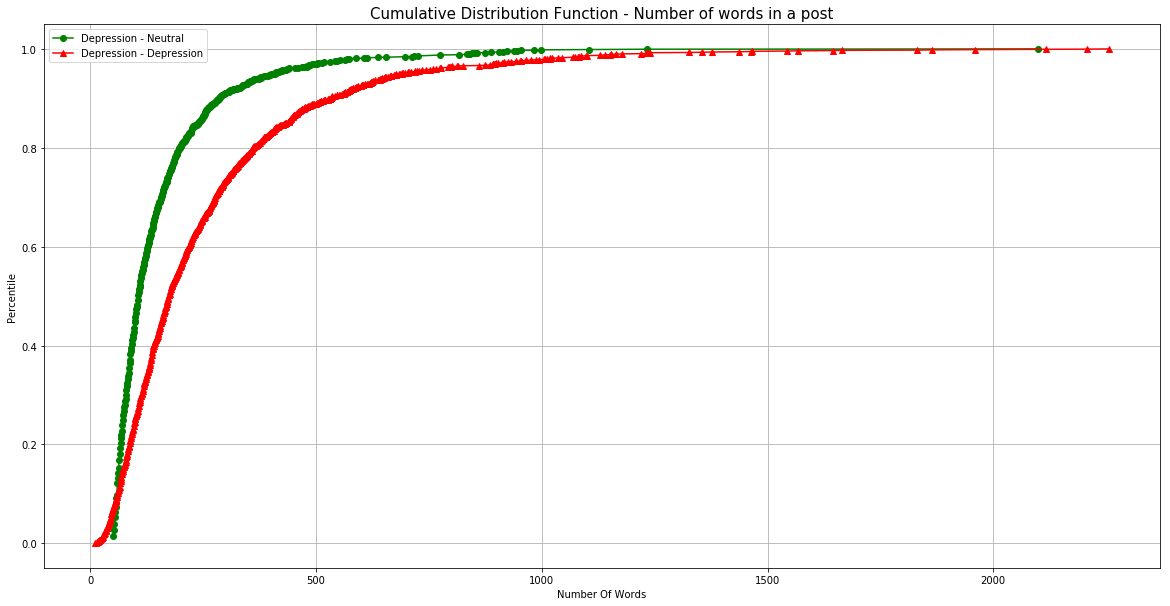

In [33]:
CDF_neutral, neutral_indice_list = generate_CDF(data=depression_group_users_neutral_posts)
CDF_depression, depression_indice_list = generate_CDF(data=depressed_group_depressed_posts)
#CDF_neutral_neutral, neutral_neutral_list = generate_CDF(data= non_depressed_people)

plt.figure(figsize=(20,10))
plt.plot(neutral_indice_list.values, CDF_neutral,color='green',marker='o', label='Depression - Neutral')
plt.plot(depression_indice_list.values, CDF_depression,color='red',marker='^', label='Depression - Depression')
#plt.plot(neutral_neutral_list.values, CDF_neutral_neutral,color='blue',marker='*', label='Neutral - Neutral')

plt.legend()
plt.title("Cumulative Distribution Function - Number of words in a post", size=15)
plt.ylabel("Percentile",size=10)
plt.xlabel("Number Of Words",size=10)
plt.grid()
plt.show()

In [34]:
# Lets drop the predicted column from our test groups
non_depressed_people = non_depressed_people.drop('predicted', axis=1)
depressed_group_depressed_posts = depressed_group_depressed_posts.drop('predicted', axis=1)

non_depressed_people['is_depressed'] = 0
depressed_group_depressed_posts['is_depressed'] = 1

In [35]:
# Combine both datasets
depressed_vs_neutral = pd.concat((non_depressed_people, depressed_group_depressed_posts), axis=0)
X = depressed_vs_neutral['post_text']
y = depressed_vs_neutral['is_depressed']

In [36]:
# Data transformation => Countvectorizer and Tfidf transformer
# removing english stopwords and analyzing on the word level
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [37]:
# Simple 80/20 ratio train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Applying a Linear Support Vector Classifier on our data
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [39]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.9337539432176656
AUC Score: 0.9748092911648596

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,504,31
actual depression,32,384


In [40]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['date' 'netflix' 'game' 'unstable' 'grandparents' 'binging' 'hug' 'idk'
 'text' 'addicted']

Largest Coefs: 
['depression' 'depressed' 'depressing' 'depressive' 'self' 'depressants'
 'hate' 'miss' 'physical' 'depressions']



In [41]:
# Now lets try to classify and destinguish between the depression groups' neutral posts
# from the neutral group's posts
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop('predicted', axis=1)
depression_group_users_neutral_posts['is_depressed'] = 1

In [42]:
depressed_vs_neutral = pd.concat((non_depressed_people, depression_group_users_neutral_posts), axis=0)
X = depressed_vs_neutral['post_text'].map(post_to_wordlist)
y = depressed_vs_neutral['is_depressed']

In [43]:
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1000,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [46]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.30267753201396974
AUC Score: 0.13876842960279162

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,248,321
actual depression,278,12


In [47]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['cst' 'desperate' 'tried' 'goal' 'history' 'numb' 'country' 'girl'
 'doctor' 'pop']

Largest Coefs: 
['cstg' 'semester' 'sword' 'option' 'bandages' 'applying' 'protagonist'
 'forever' 'pity' 'loser']

